# A high-level look at the population of Texas law enforcement sworn officers

## Summary of findings
* There are about 75,000 sworn police officers in Texas.
* About 60% are white, 30% hispanic, 10% black.
* About 90% are men.
* Younger officers, and black or hispanic officers, are disproportionately female.
* High-population counties have disproportionately many minority officers (especially black -- but also hispanic, female, and other races)

### Datasets used:
* `tji/auxiliary-datasets/list_of_texas_officers`
* `tji/auxiliary-datasets/census_data_by_county` (For county populations)

##### Author: Everett Wetchler (everett.wetchler@gmail.com)

In [1]:
from lib import eda

/Users/everettwetchler/.virtualenvs/tji-analysis/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

import datetime as dt
import os
import random

import datadotworld as dw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Jupyter setup
%matplotlib inline

## Graphical setup
# Useful colors to reference
SNS_BLUE, SNS_GREEN, SNS_RED, SNS_PURPLE, SNS_YELLOW, SNS_CYAN = sns.color_palette()
SNS_COLORS = sns.color_palette()
# sns.set_palette(sns.color_palette("cubehelix", 8))
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# Watermark extension to print version/system information
# Flags:
# -a [author] -d (date) -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version) -p [packages] (package info)
%load_ext watermark
%watermark -a "Everett Wetchler" -d -t -z -w -p numpy,pandas,matplotlib,datadotworld

####################################################
# END Boilerplate
####################################################

Everett Wetchler 2018-05-14 21:40:44 CDT

numpy 1.14.3
pandas 0.20.1
matplotlib 2.2.0
datadotworld 1.6.0
watermark 1.5.0


In [3]:
SAVE_PLOTS = True
PLOT_DIR= '../plots/'
PLOT_PREFIX = 'officer_population_'

# Helper function to (optionally) save and name plots)
plotcount = 0
def saveplot(fig, name):
    if SAVE_PLOTS:
        global plotcount
        plotcount += 1
        filename = os.path.join(PLOT_DIR, PLOT_PREFIX + "%02d_%s.png" % (plotcount, name))
        fig.savefig(filename)

if SAVE_PLOTS:
    prev_plots = [f for f in os.listdir(PLOT_DIR) if f.startswith(PLOT_PREFIX)]
    print("Removing %d past plots" % len(prev_plots))
    for f in prev_plots:
        os.remove(os.path.join(PLOT_DIR, f))

Removing 8 past plots


In [4]:
def long_gender(g):
    if pd.isnull(g):
        return g
    return 'MALE' if g == 'M' else 'FEMALE'

## Load and merge data

In [5]:
dataset = dw.load_dataset('tji/auxiliary-datasets', force_update=True)
officer_info = dataset.dataframes['list_of_texas_officers']
officer_info['gender'] = officer_info['gender'].apply(long_gender)
officer_info['highest_cert_abbr'] = officer_info['highest_cert'].apply(lambda cert: cert.split(' PEACE OFFICER')[0])
officer_info['service_years_int_capped'] = officer_info.service_time.astype(int).apply(lambda y: min(y, 50))

In [6]:
dataset = dw.load_dataset('tji/auxiliary-datasets', force_update=True)
census = dataset.dataframes['census_data_by_county']
census.columns = [c.upper() for c in census.columns]
county_populations = census[census['METRIC_DESCRIPTION'] == 'Population estimates, July 1, 2016,  (V2016)'].iloc[0]
county_populations.drop(['METRIC_CATEGORY', 'METRIC_SUBCATEGORY', 'METRIC_DESCRIPTION', 'ALL_TEXAS'], inplace=True)
county_populations = county_populations.astype(int).to_dict()

def pop_category(p):
    if pd.isnull(p):
        return p
    elif p < 1e4:
        return 'XSMALL\n(< 10k)'
    elif p < 1e5:
        return 'SMALL\n(< 100k)'
    elif p < 1e6:
        return 'MEDIUM\n(100k-1MM)'
    else:
        return 'LARGE\n(1MM+)'

officer_info['county_size'] = officer_info.current_agency_county.apply(
    lambda c: pop_category(county_populations.get(c, None)))

officer_info.sample(10)

,name_full,name_first,name_middle,name_last,name_suffix,gender,race,age_range,current_agency,current_agency_county,highest_cert,highest_cert_int,service_time,highest_cert_abbr,service_years_int_capped,county_size
74727,ANTHONY CARRILLO JR,ANTHONY,NaN,CARRILLO,JR,MALE,HISPANIC,41-50,LAREDO POLICE DEPT,WEBB,MASTER PEACE OFFICER,4,24.42,MASTER,24,MEDIUM\n(100k-1MM)
68482,GLEN R SHAW,GLEN,R,SHAW,NaN,MALE,WHITE,41-50,TARRANT CO SHERIFFS OFFICE,TARRANT,MASTER PEACE OFFICER,4,25.50,MASTER,25,LARGE\n(1MM+)
64629,JESSIE L ROGERS,JESSIE,L,ROGERS,NaN,MALE,BLACK,51+,ARLINGTON POLICE DEPT,TARRANT,MASTER PEACE OFFICER,4,28.33,MASTER,28,LARGE\n(1MM+)
50957,BRYAN M DUBOSE,BRYAN,M,DUBOSE,NaN,MALE,WHITE,51+,MONTGOMERY CO CONST PCT 1,MONTGOMERY,MASTER PEACE OFFICER,4,32.91,MASTER,32,MEDIUM\n(100k-1MM)
9136,LUKE M ARREGUIN,LUKE,M,ARREGUIN,NaN,MALE,HISPANIC,21-30,PORT LAVACA POLICE DEPT,CALHOUN,BASIC PEACE OFFICER,1,1.00,BASIC,1,SMALL\n(< 100k)
77499,MARIO H GARCIA JR,MARIO,H,GARCIA,JR,MALE,WHITE,41-50,ZAPATA CO ISD POLICE DEPT,ZAPATA,MASTER PEACE OFFICER,4,21.84,MASTER,21,SMALL\n(< 100k)
51922,SHAWN R HUBBARD,SHAWN,R,HUBBARD,NaN,MALE,WHITE,31-40,CACTUS POLICE DEPT,MOORE,MASTER PEACE OFFICER,4,11.08,MASTER,11,SMALL\n(< 100k)
31904,DAVID W HASTEN,DAVID,W,HASTEN,NaN,MALE,WHITE,51+,HARRIS CO SHERIFFS OFFICE,HARRIS,MASTER PEACE OFFICER,4,34.50,MASTER,34,LARGE\n(1MM+)
28003,CHARLES T DUKES,CHARLES,T,DUKES,NaN,MALE,WHITE,51+,KILGORE POLICE DEPT,GREGG,ADVANCED PEACE OFFICER,3,16.92,ADVANCED,16,MEDIUM\n(100k-1MM)
26161,SYLVIA A CHAPA,SYLVIA,A,CHAPA,NaN,FEMALE,HISPANIC,51+,COLLEGE OF THE MAINLAND POLICE DEPT,GALVESTON,MASTER PEACE OFFICER,4,17.34,MASTER,17,MEDIUM\n(100k-1MM)


## Begin analysis

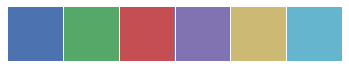

In [7]:
sns.palplot(sns.color_palette())

In [8]:
plot_order = ['age_range', 'race', 'gender', 'service_years_int_capped', 'county_size', 'highest_cert_abbr']
col_colors = {
    'gender': [SNS_RED, SNS_BLUE],
    'race': ['gray', SNS_YELLOW, SNS_BLUE, SNS_GREEN],
    'age_range': sns.color_palette('Blues_d', 4)[::-1],
    'county_size': sns.color_palette('Greens_d', 4)[::-1],
    'service_years_int_capped': [SNS_BLUE],
    'highest_cert_abbr': sns.color_palette()[:-1],
}
order = {
    'gender': ['FEMALE', 'MALE'],
    'race': ['WHITE', 'HISPANIC', 'BLACK', 'OTHER'],
    'age_range': ['21-30', '31-40', '41-50', '51+'],
    'county_size': ['XSMALL\n(< 10k)', 'SMALL\n(< 100k)', 'MEDIUM\n(100k-1MM)', 'LARGE\n(1MM+)'],
    'highest_cert_abbr': ['NONE', 'BASIC', 'INTERMEDIATE', 'ADVANCED', 'MASTER'],
}
col_printname = {
    'gender': 'Gender',
    'race': 'Race',
    'age_range': 'Age',
    'county_size': 'County Size',
    'service_years_int_capped': 'Service Time (years)',
    'highest_cert_abbr': 'Certification Level',
}
nostack = {'service_years_int_capped', 'highest_cert_abbr'}

def make_grid_plot(stack_col=None, alpha=0.8): 
    nrows = 3#2 if stack_col else 3
    fig, axes = plt.subplots(nrows, 2)
    axes = axes.flatten()

    fig.set_size_inches(18, 6 * nrows)
    if not stack_col:
        fig.suptitle("OVERVIEW - %s Texas police officers, as of May 2018" % "{:,}".format(len(officer_info)), fontsize=24)
    else:
        fig.suptitle("CROSSTAB - officer demographics by " + col_printname[stack_col], fontsize=24)

    iax = 0
    for by_col in plot_order:
        if by_col == stack_col:
            continue
        ax = axes[iax]
        iax += 1
        if stack_col:
            vc = officer_info.groupby([by_col, stack_col]).size().unstack()
            vc = vc.div(vc.sum(axis=1), axis=0)
            vc = vc[order[stack_col]]
            color = col_colors[stack_col]
        else:
            vc = officer_info[by_col].value_counts(True)
            color = col_colors[by_col][::-1]

        if by_col == 'service_years_int_capped':
            vc = vc.sort_index()
            vc.plot(kind='bar', ax=ax, width=1, stacked=True, color=color, alpha=alpha)
            if stack_col:
                ax.set_ylim(0, 1.01)
                ax.set_yticks(np.arange(0, 1.01, .1))
            ax.set_xticklabels([(t.get_text() if int(t.get_text()) % 5 == 0 else '')
                                for t in ax.get_xticklabels()], rotation=0)
            ax.set_ylabel("Fraction of officers")
            ax.set_xlabel(col_printname[by_col])
            eda.percentify_y(ax, decimals=0)
        else:
            vc = vc.loc[order[by_col]][::-1]
            vc.plot(kind='barh', ax=ax, width=.9, stacked=True, color=color, alpha=alpha)
            if stack_col:
                ax.set_xlim(0, 1.01)
                ax.set_xticks(np.arange(0, 1.01, .1))
            ax.set_xlabel("Fraction of officers")
            ax.set_ylabel(col_printname[by_col])
            eda.percentify_x(ax, decimals=0)

        if stack_col:
            ax.set_title("%s distribution by %s" % (col_printname[stack_col], col_printname[by_col]))
            ax.legend()
        else:
            ax.set_title("By %s" % (col_printname[by_col]))
        plt.subplots_adjust(hspace=0.4, wspace=0.4, left=0.16)

    saveplot(fig, (stack_col or 'overview') + '_grid')

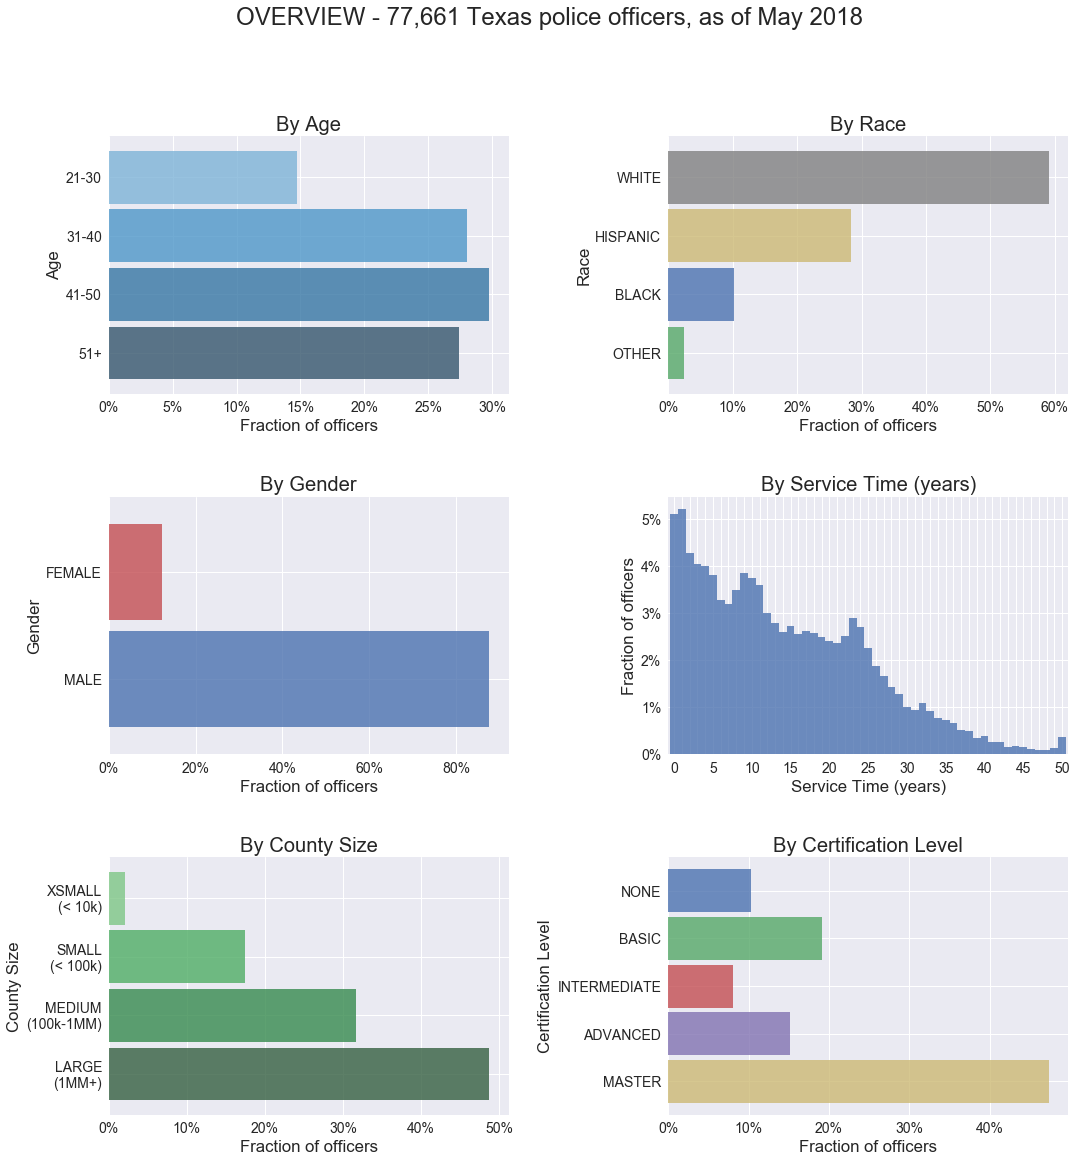

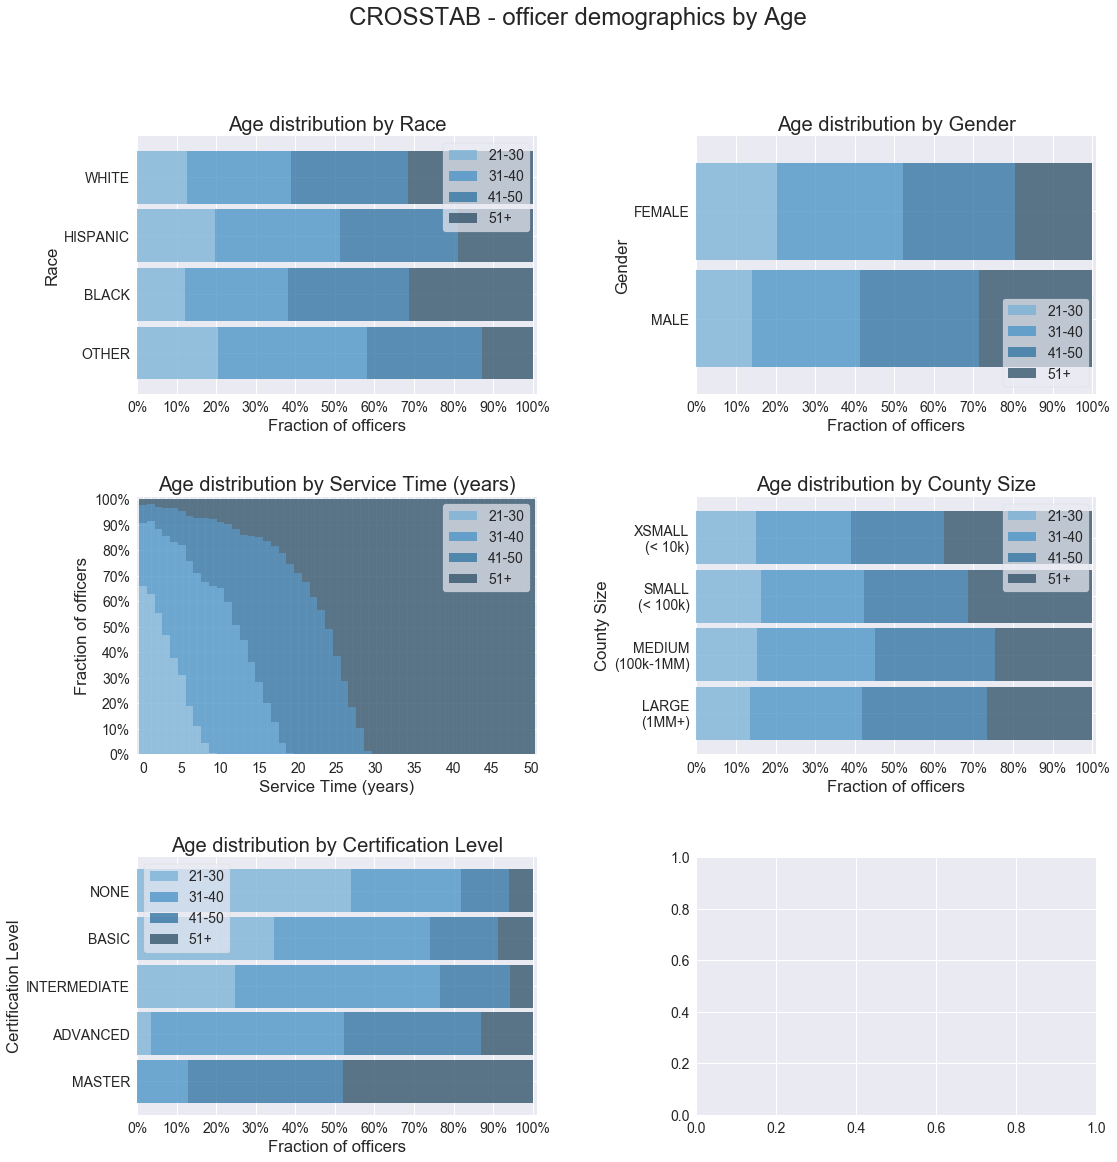

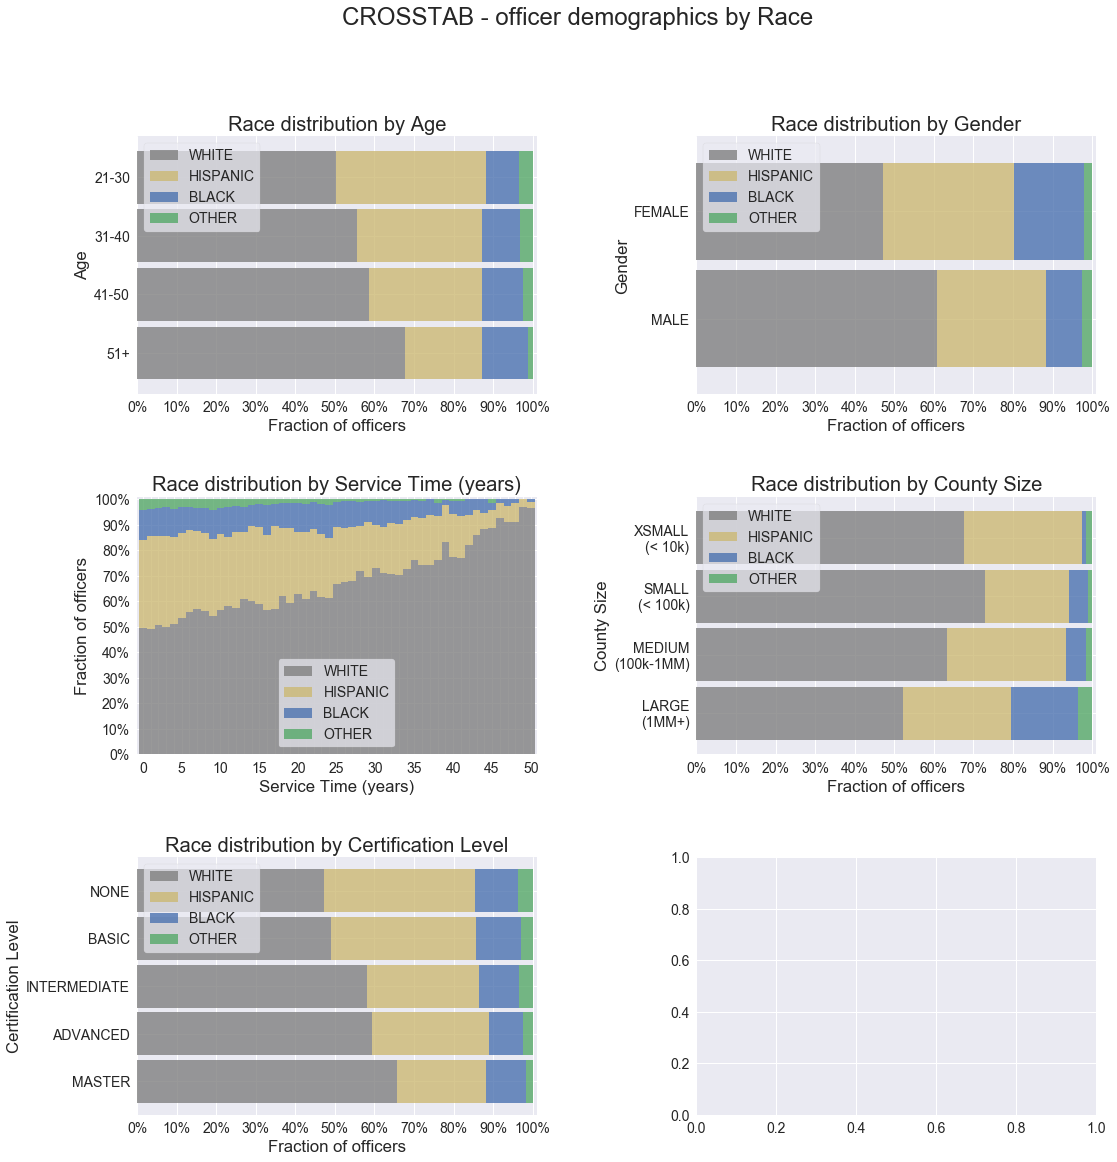

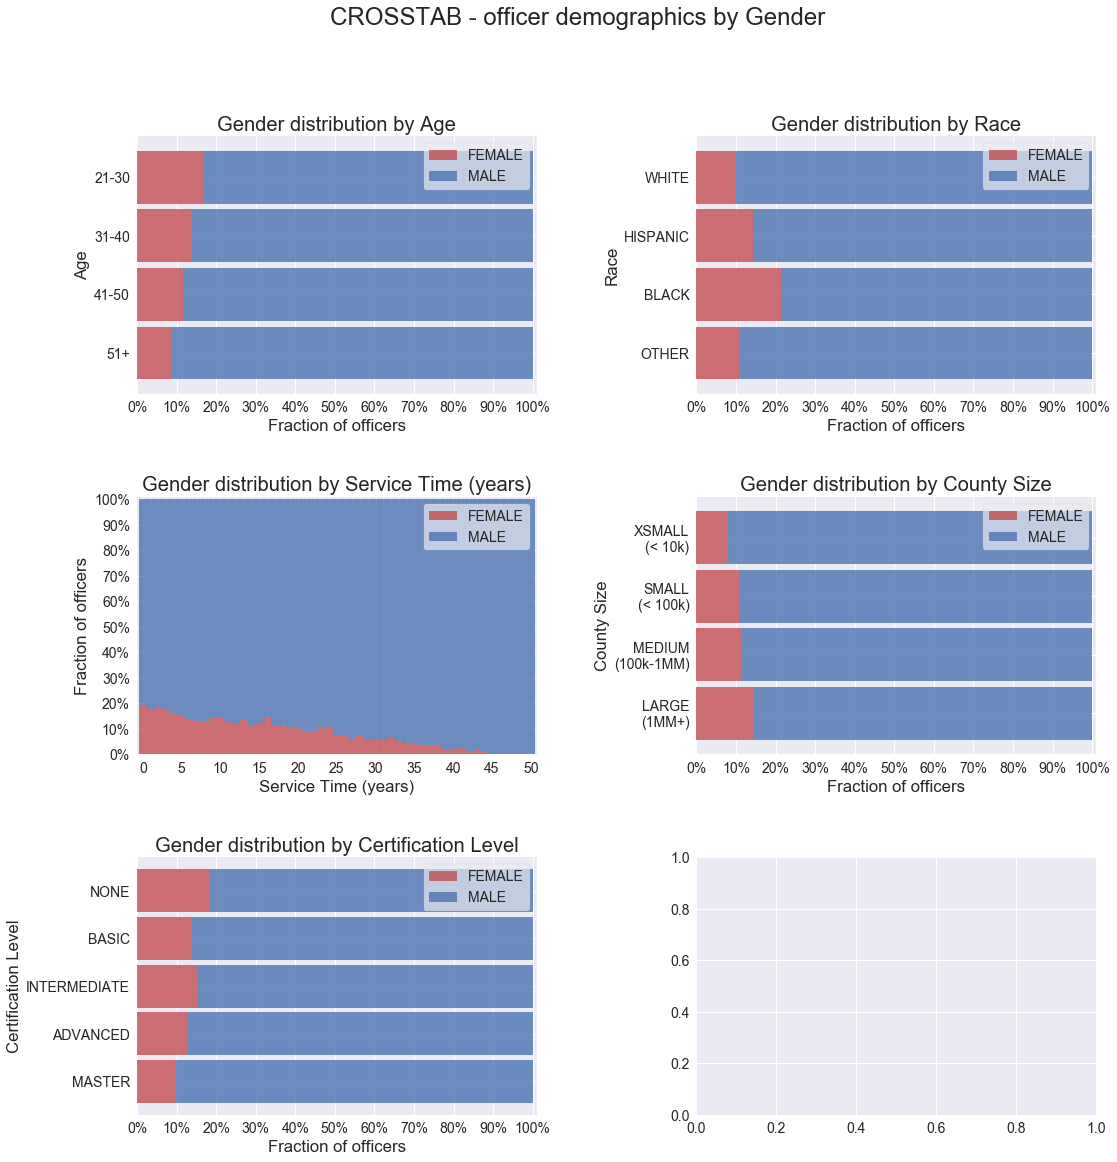

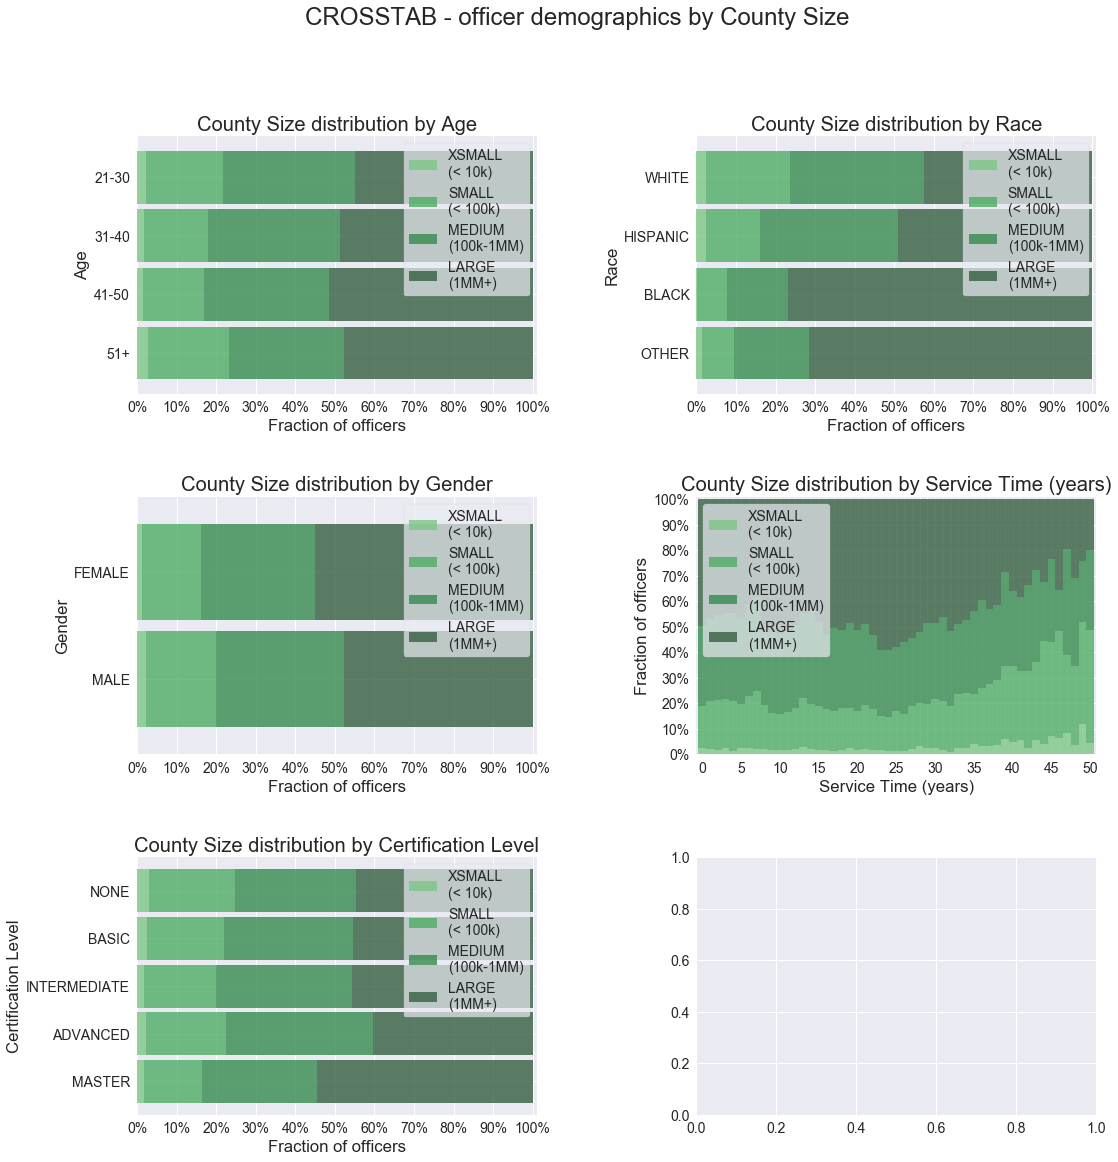

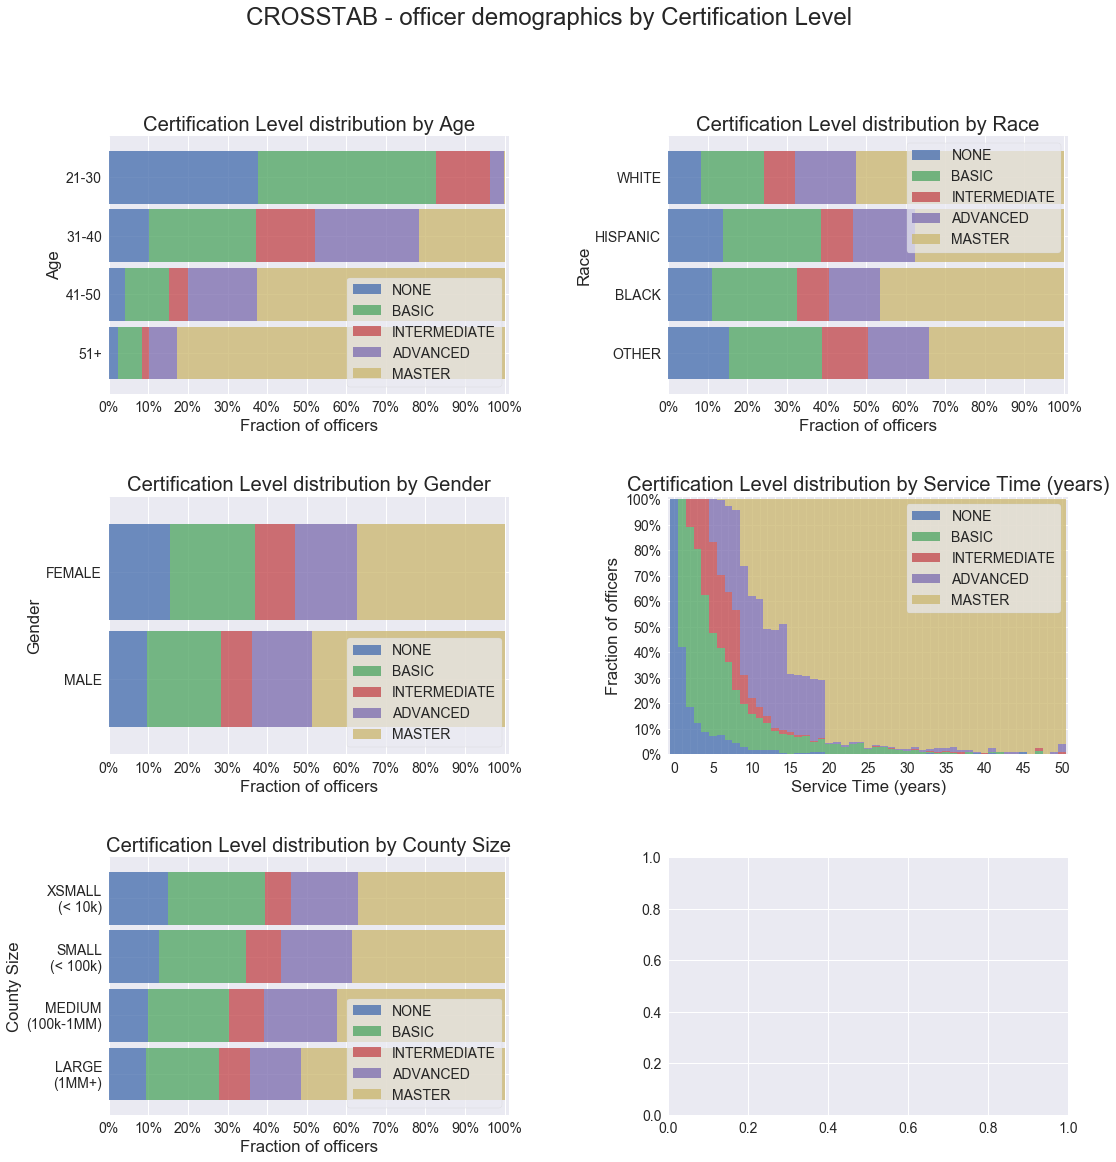

In [9]:
for by in [None] + plot_order:
    if by == 'service_years_int_capped':
        continue
    make_grid_plot(by)

## Another look at gender

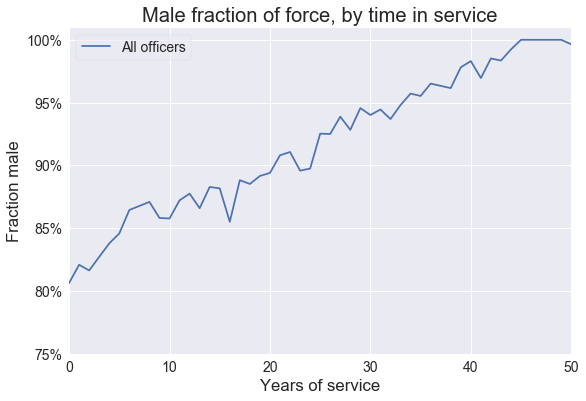

In [10]:
officer_info['is_male'] = officer_info.gender == 'MALE'
fig, ax = plt.subplots(1)
officer_info.groupby('service_years_int_capped')['is_male'].mean().plot(label='All officers')
ax.set_title('Male fraction of force, by time in service')
ax.set_xlabel('Years of service')
ax.set_ylabel('Fraction male')
ax.set_yticks(np.arange(.75, 1.01, .05))
eda.percentify_y(ax, decimals=0)
ax.legend()
saveplot(fig, 'male_fraction_by_service_years')

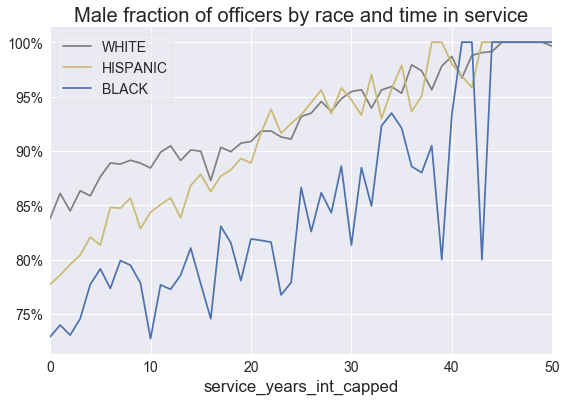

In [11]:
fig, ax = plt.subplots(1)
for race, color in zip(order['race'], col_colors['race']):
    if race == 'OTHER':
        continue
    frame = officer_info[officer_info.race == race]
    s = frame.groupby('service_years_int_capped')['is_male'].mean().sort_index()
    s.plot(kind='line', label=race, color=color)

eda.percentify_y(ax, decimals=0)
ax.legend()
ax.set_title('Male fraction of officers by race and time in service')
saveplot(fig, 'male_fraction_by_race_and_service_years')